# Home Cage Dopamine Analysis

In [17]:
import os
import sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PROJECT_ROOT)

from trial_class import *
from experiment_class import Experiment

from hc_extension import *
from bouts_extension import *

In [18]:
# NAc: #15616F
# mPFC: #FFAF00

# NAc
# experiment_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\nac"
# csv_base_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\nac_csvs"
# brain_region = '#15616F'

# mPFC
experiment_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\mpfc"
csv_base_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\mpfc_csvs"
brain_region = '#FFAF00'

In [19]:
# # NAc: #15616F
# # mPFC: #FFAF00

# # NAc
# experiment_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\nac"
# csv_base_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\nac_csvs"
# brain_region = '#15616F'

# # mPFC
# # experiment_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\mpfc"
# # csv_base_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\mpfc_csvs"
# # brain_region = '#FFAF00'

In [20]:
# groups csv + experiment data into one variable
experiment = Experiment(experiment_path, csv_base_path)

# batch process the data, removing the specified time segments for subjects
experiment.default_batch_process()

Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\mpfc\p1-240508-084607\Notes.txt
read from t=0s to t=1812.36s
Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\mpfc\p2-240508-101128\Notes.txt
read from t=0s to t=1820.76s
Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\mpfc\p3-240509-070801\Notes.txt
read from t=0s to t=1818.93s
Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\mpfc\p5-240823-093250\Notes.txt
read from t=0s to t=1794.17s
Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\mpfc\p6-240823-105552\Notes.txt
read from t=0s to t=1807.06s
Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\mpfc\p7-240824-053845\Notes.txt
rea

In [21]:
bout_definitions = [
    {'prefix': 'Short_Term', 'introduced': 'Short_Term_Introduced', 'removed': 'Short_Term_Removed'},
    {'prefix': 'Long_Term', 'introduced': 'Long_Term_Introduced', 'removed': 'Long_Term_Removed'},
    {'prefix': 'Novel', 'introduced': 'Novel_Introduced', 'removed': 'Novel_Removed'}
]

experiment.group_extract_manual_annotations(bout_definitions, first_only=True)

Processing behaviors for p1-240508-084607...
Processing behaviors for p2-240508-101128...
Processing behaviors for p3-240509-070801...
Processing behaviors for p5-240823-093250...
Processing behaviors for p6-240823-105552...
Processing behaviors for p7-240824-053845...
Processing behaviors for p8-240824-070451...
Processing behaviors for pp1-250120-094415...
Processing behaviors for pp2-250121-123301...
Processing behaviors for pp3-250121-055222...
Processing behaviors for pp4-250121-065035...
Processing behaviors for pp5-250121-110144...
Processing behaviors for pp6-250121-114116...
Processing behaviors for pp7-250121-134131...
Processing behaviors for pp8-250121-142227...


### Peak standard z-score

In [22]:
experiment.compute_all_da_metrics(max_bout_duration=4, 
                                  mode='standard')

Computing DA metrics for p1-240508-084607 ...
Computing DA metrics for p2-240508-101128 ...
Computing DA metrics for p3-240509-070801 ...
Computing DA metrics for p5-240823-093250 ...
Computing DA metrics for p6-240823-105552 ...
Computing DA metrics for p7-240824-053845 ...
Computing DA metrics for p8-240824-070451 ...
Computing DA metrics for pp1-250120-094415 ...
Computing DA metrics for pp2-250121-123301 ...
Computing DA metrics for pp3-250121-055222 ...
Computing DA metrics for pp4-250121-065035 ...
Computing DA metrics for pp5-250121-110144 ...
Computing DA metrics for pp6-250121-114116 ...
Computing DA metrics for pp7-250121-134131 ...
Computing DA metrics for pp8-250121-142227 ...


In [23]:
exp_da_dict = get_trial_dataframes(experiment)

In [24]:
desired_bouts = ['Short_Term-1', 'Novel-1', 'Short_Term-2', 'Long_Term-1']
da_metadata_df = create_da_metrics_dataframe(exp_da_dict, behavior="Investigation", desired_bouts=desired_bouts)

In [25]:
# Copy original DataFrame
ordered_df = da_metadata_df.copy()

# Desired bout order
desired_bout_order = ["Short_Term-1", "Short_Term-2", "Long_Term-1", "Novel-1"]

# 1. Filter and reorder Bout as categorical
ordered_df = ordered_df[ordered_df["Bout"].isin(desired_bout_order)].copy()
ordered_df["Bout"] = pd.Categorical(ordered_df["Bout"], categories=desired_bout_order, ordered=True)

# 2. Call the plot function (it will respect the categorical order when pivoted)

In [26]:
ordered_df.head()

,Subject,Bout,Behavior,AUC,Max Peak,Mean Z-score
0,p1,Short_Term-1,Investigation,1.587773,1.578218,1.403235
1,p1,Novel-1,Investigation,3.839354,2.154880,1.799729
2,p1,Short_Term-2,Investigation,-0.811805,-0.916075,-1.061339
3,p1,Long_Term-1,Investigation,0.271765,0.395254,0.099534
4,p2,Short_Term-1,Investigation,7.167258,1.439788,0.676152


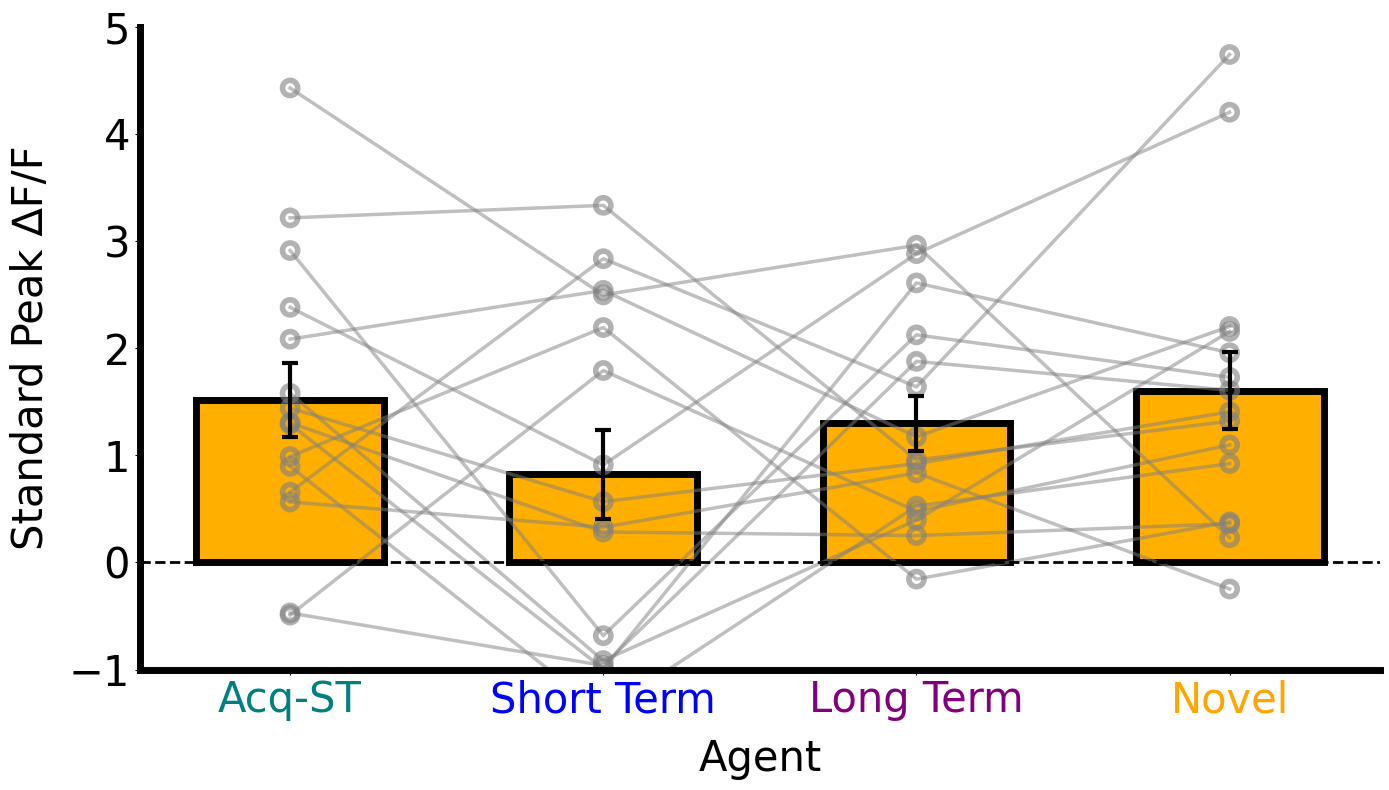


Paired t-test results (all pairwise combinations):
Short_Term-1 vs Short_Term-2: p = 0.1414 (ns), d = 0.402
Short_Term-1 vs Long_Term-1: p = 0.5043 (ns), d = 0.177
Short_Term-1 vs Novel-1: p = 0.8661 (ns), d = -0.044
Short_Term-2 vs Long_Term-1: p = 0.3526 (ns), d = -0.248
Short_Term-2 vs Novel-1: p = 0.1498 (ns), d = -0.393
Long_Term-1 vs Novel-1: p = 0.3869 (ns), d = -0.231


In [32]:
plot_behavior_across_bouts_no_identities(
    metadata_df=ordered_df,
    y_col="Max Peak",
    ylabel="Standard Peak ∆F/F",
    xlabel="Agent",
    custom_xtick_labels=["Acq-ST", "Short Term", "Long Term", "Novel"],
    custom_xtick_colors=["teal", "blue", "purple", "orange"],
    ylim=(-1, 5),
    yticks_increment=1,
    bar_color=brain_region,
    figsize=(14, 8),
    save=None,
    save_name ="mDA",
    title=None
)

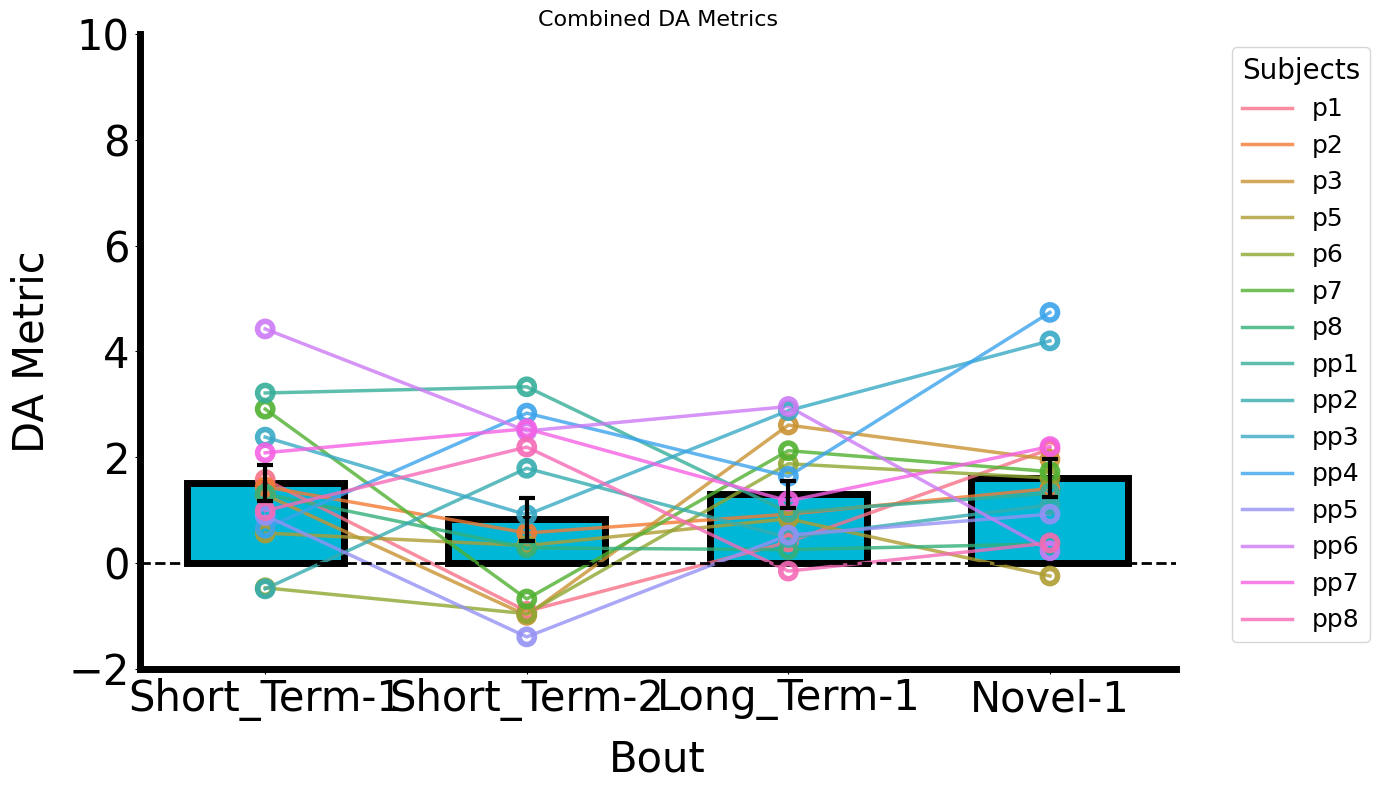

In [28]:
plot_behavior_across_bouts_with_identities(
    metadata_df=ordered_df,
    y_col="Max Peak",
    title="Combined DA Metrics", 
    ylabel="DA Metric", 
    xlabel="Bout", 
    custom_xtick_labels=None, 
    custom_xtick_colors=None, 
    ylim=(-2,10), 
    bar_color="#00B7D7", 
    yticks_increment=None, 
    figsize=(14,8), 
    pad_inches=0.1,
    save=False,
    save_name=None
)

In [29]:
experiment.reset_all_behaviors()
experiment.group_extract_manual_annotations(bout_definitions=bout_definitions, first_only = False)

# total_avg_bout_duration = metadata_df["Average Bout Duration"].mean()
# print(f"Total Average Bout Duration: {total_avg_bout_duration:.4f}")
# Proceed with DA metric computation after all files are processed
experiment.compute_all_da_metrics(max_bout_duration=4,
                                  mode='standard')

Processing behaviors for p1-240508-084607...
Processing behaviors for p2-240508-101128...
Processing behaviors for p3-240509-070801...
Processing behaviors for p5-240823-093250...
Processing behaviors for p6-240823-105552...
Processing behaviors for p7-240824-053845...
Processing behaviors for p8-240824-070451...
Processing behaviors for pp1-250120-094415...
Processing behaviors for pp2-250121-123301...
Processing behaviors for pp3-250121-055222...
Processing behaviors for pp4-250121-065035...
Processing behaviors for pp5-250121-110144...
Processing behaviors for pp6-250121-114116...
Processing behaviors for pp7-250121-134131...
Processing behaviors for pp8-250121-142227...
Computing DA metrics for p1-240508-084607 ...
Computing DA metrics for p2-240508-101128 ...
Computing DA metrics for p3-240509-070801 ...
Computing DA metrics for p5-240823-093250 ...
Computing DA metrics for p6-240823-105552 ...
Computing DA metrics for p7-240824-053845 ...
Computing DA metrics for p8-240824-070451

## DA across Subsequent Bouts

In [30]:
exp_da_dict = get_trial_dataframes(experiment)

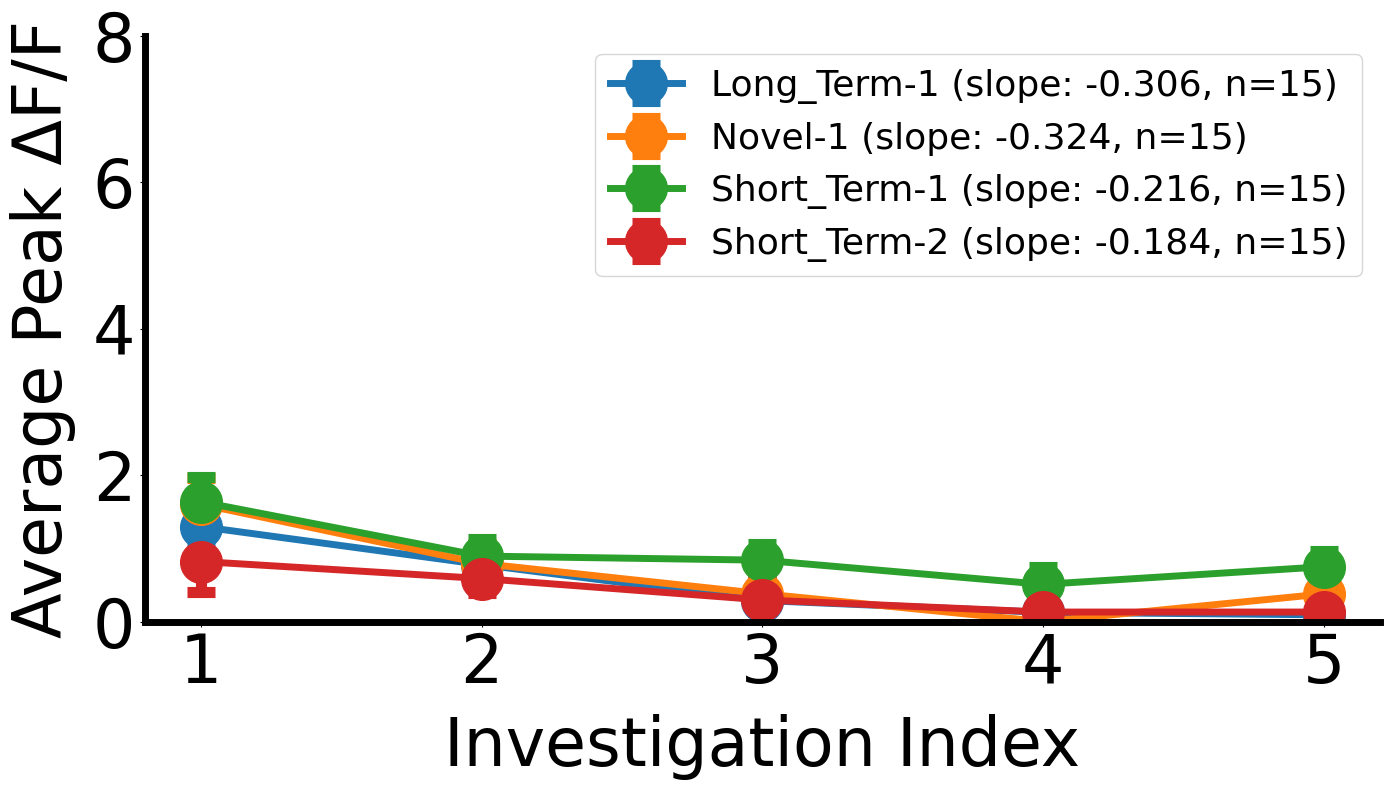


=== Computed Metric (SLOPE): ===
Bout: Long_Term-1, slope = -0.306
Bout: Novel-1, slope = -0.324
Bout: Short_Term-1, slope = -0.216
Bout: Short_Term-2, slope = -0.184


,Bout,BehaviorIndex,SubjectCount,AvgPeak,StdPeak,SEM
0,Long_Term-1,1,15,1.297550,0.996210,0.257220
1,Long_Term-1,2,15,0.778542,0.846902,0.218669
2,Long_Term-1,3,15,0.288084,0.620709,0.160266
3,Long_Term-1,4,15,0.127330,1.070400,0.276376
4,Long_Term-1,5,14,0.092804,0.838552,0.224112
5,Novel-1,1,15,1.603183,1.377814,0.355750
6,Novel-1,2,15,0.793237,1.047152,0.270373
7,Novel-1,3,15,0.381105,0.786454,0.203062
8,Novel-1,4,15,0.000292,0.833121,0.215111
9,Novel-1,5,15,0.378416,0.679057,0.175332


In [31]:
plot_peak_for_subsequent_behaviors(
    exp_da_dict,
    behavior="Investigation",
    selected_bouts=["Short_Term-1", "Short_Term-2", "Long_Term-1", "Novel-1"],
    n_subsequent_behaviors=5,
    peak_col="Max Peak",
    metric_type='slope', 
    xlabel="Investigation Index",
    ylabel="Average Peak ΔF/F",
    ylim=(0, 8),
    ytick_increment=2,
    plot_title="",
    save = False,
    save_path=r"Home_Cage_Plots\mPFC_DA\peaks_for_subsequent_behaviors.png" 
)